### Imports

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
from numpy.matlib import repmat
import cvxpy as cvx
import gurobipy as grb

### Problem 1 : *Censored data fitting* (2 points). 

In [5]:
# data for censored fitting problem

n = 2  # dimension of x's
M = 3  # number of non-censored data points
K = 5 # total number of points

r = np.random.RandomState(1)
c_true = r.randn(n)
X = r.randn(n, K)
y = np.dot(X.T, c_true) + 0.1 * np.sqrt(n) * r.randn(K)


sort_ind = np.argsort(y)
full = y[sort_ind]
print 'Full data:', full.ravel()
X = X[:, sort_ind];
y = y[sort_ind[:M + 1]]
D = (y[M - 1]+y[M]) / 2
y = y[:M]

print 'Without censored patterns:', y.ravel()


Full data: [-4.78849573 -1.99235931 -0.43785681  1.71861401  4.07009616]
Without censored patterns: [-4.78849573 -1.99235931 -0.43785681]


### Solution

The problem with censored data can be considered as a optimization task with restrictions of equality (for $x, y_1, \dots, y_M$ we have certain values) and inequality (for $y_{M+1}, \dots, y_K \geq D$), $c$ has no restrictions. 

In [6]:
C = cvx.Variable(n)
Y = cvx.Variable(K)

constraints = []

for i in range(M):
    constraints.append(Y[i] == y[i])

for i in range(M + 1, K):
    constraints.append(Y[i] < D)

objective = cvx.Minimize(cvx.sum_squares(Y.T - C.T * X))

solution = cvx.Problem(objective, constraints)
solution.solve(solver = 'GUROBI')

c = C.value

print('Optimal value is: {0}'.format(solution.value))
print('Regression coefficions c = {0}'.format(C.value.ravel()))
print('Censored values y = {0}'.format(Y.value[M:].ravel()))
print 'True c = {0}'.format(c_true)
print('True censored values y = {0}'.format(full[M:].ravel()))

Optimal value is: 4.76409828997
Regression coefficions c = [[ 2.00695888  0.73976612]]
Censored values y = [[ 1.55236177  0.6403786 ]]
True c = [ 1.62434536 -0.61175641]
True censored values y = [ 1.71861401  4.07009616]


In [7]:
C = cvx.Variable(n)
Y = cvx.Variable(M)

constraints = []

for i in range(M):
    constraints.append(Y[i] == y[i])

objective = cvx.Minimize(cvx.sum_squares(Y.T - C.T * X[:,:M]))

solution = cvx.Problem(objective, constraints)
solution.solve(solver = 'GUROBI')

c_ls = C.value

print('Optimal value is: {0}'.format(solution.value))
print('Regression coefficions c = {0}'.format(C.value.ravel()))
print('Unncensored y = {0}'.format(Y.value.ravel()))
print 'True c = {0}'.format(c_true)
print('True censored values y = {0}'.format(full[M:].ravel()))

Optimal value is: 0.000365613044681
Regression coefficions c = [[ 1.69238184 -0.60646316]]
Unncensored y = [[-4.78849573 -1.99235931 -0.43785681]]
True c = [ 1.62434536 -0.61175641]
True censored values y = [ 1.71861401  4.07009616]


In [10]:
print 'Relative errors:\n', np.linalg.norm(c_true - c.T)/np.linalg.norm(c_true) 
print np.linalg.norm(c_true - c_ls.T)/np.linalg.norm(c_true)

Relative errors:
0.809250793986
0.0393161621585


### Problem 2: *Optimal vehicle speed scheduling (3 points) *-- (additional exercise A3.20 to Boyd and Vandenberghe). 

A vehicle (say, an airplane) travels along a fixed path of *n* segments, between *n + 1* waypoints labeled *0, . . . , n*. Segment *i* starts at waypoint *i − 1* and terminates at waypoint *i*. The vehicle starts at time *t = 0* at waypoint *0*. It travels over each segment at a constant (nonnegative) speed; *si* is the speed on segment *i*. We have lower and upper limits on the speeds: *smin ≤ s ≤ smax*. The vehicle does not stop at the waypoints; it simply proceeds to the next segment. The travel distance of segment *i* is *di* (which is positive), so the travel time over segment *i* is *di/si*. We let *τi*, *i = 1, . . . , n,* denote the time at which the vehicle arrives at waypoint *i*. The vehicle is required to arrive at waypoint *i*, *for i = 1, . . . , n*, between times *τmin,i* and *τmax,i* , which are given. The vehicle consumes fuel over segment *i* at a rate that depends on its speed *Φ(s_i )=a s_i^2+b s_i+c kg/s*.

You are given the data *d* (segment travel distances), *smin* and *smax* (speed bounds), *τmin* and *τmax* (waypoint arrival time bounds), and the the parameters *a*, *b*, and *c* (all parameters are in *veh_speed_sched_data.m*). For the given form of the potentials, find the way to reduce the problem to a convex optimization problem and solve it using CVX (NB: you need not necessarily use one of the “canonical” convex optimization formulations we saw in the course). Use MATLAB command stairs to plot speed vs time for the optimal schedule.  What are relative pros and cons for using convex optimization vs. dynamic programming for such task?

### Solution

$$\Phi (t_i) = a \big(\frac{d_i}{t_i}\big)^2 + b \frac{d_i}{t_i} + c$$

Let's consider times for traveling between all layers $i$ and $i+1$ $t_i$ as a variable of our optimization problem. Then, firstly, we have constraints 
$$\sum_{k = 1}^it_k \in [\tau_{min}, \tau_{max}]_i$$ 
Secondly, as $d_i = s_it_i$ we have another constraints 
$$ s_{min}t_i < d_i < s_{max}t_i$$

\begin{equation*}
\begin{aligned}
& \underset{x}{\text{minimize}}
& & \sum_{i = 1}^n \Phi(t_i) \\
& \text{subject to}
& & \sum_{k = 1}^it_k \in [\tau_{min}, \tau_{max}]_i \\
&&& t_i \leq \frac{d_i}{s_{min}^i} \\
&&& t_i \geq \frac{d_i}{s_{max}^i}
\end{aligned}
\end{equation*}

* Pro of the CVXPY is simplicity of implementstion, as with undestanding of the problem key parts, it help to avoid organization problems with dinamic algorithm (and I had an huge amounts of bags there!!). 
* Working time is another good pro of CVXPY: 

---- dinamic: 1 loops, best of 3: 14.2 s per loop 

---- cvxpy: 1 loops, best of 3: 901 ms per loop
* In dinamic programming I had to divide the time intervals into discrete points and the solution certanly depends on this division

*Con is that even CVXPY is sometimes quite buggy :)

In [69]:
import scipy.io as sio

mat_contents = sio.loadmat('veh_sched_data.mat')

a = mat_contents['a'].ravel()[0]
b = mat_contents['b'].ravel()[0]
c = mat_contents['c'].ravel()[0]
d = mat_contents['d'].ravel()
n = mat_contents['n'].ravel()[0]
smin = mat_contents['smin'].ravel()
smax = mat_contents['smax'].ravel()
tau_min = mat_contents['tau_min'].ravel()
tau_max = mat_contents['tau_max'].ravel()



In [73]:
T = cvx.Variable(n)

constraints = []

for i in range(0, n):
    constraints.append(cvx.sum_entries(T[0:i+1]) <= tau_max[i])
    constraints.append(cvx.sum_entries(T[0:i+1]) >= tau_min[i])
    constraints.append(T[i] <= d[i]/smin[i])
    constraints.append(T[i] >= d[i]/smax[i])

fuel_sum = a*cvx.sum_squares(T) + b*cvx.sum_entries(T) + c
objective = cvx.Minimize(fuel_sum)

solution = cvx.Problem(objective, constraints)
solution.solve(solver = 'GUROBI')

print('Optimal value is: {0}'.format(solution.value))
print('T = {0}'.format(T.value.ravel()))

Optimal value is: 1186.04657248
T = [[ 1.73345763  1.73213164  1.73027167  1.72831382  1.73588695  1.72903505
   1.86664089  1.0604956   1.88475394  1.71885512  1.88391623  1.88565394
   1.8852186   1.88451118  1.77929455  1.83066376  1.80599945  1.69011185
   1.69140086  3.32152255  1.67173738  1.67213559  1.66958358  1.66862658
   1.17654954  1.02733171  1.00722625  1.62071515  1.64227924  1.64270033
   1.642197    1.64215676  1.64169975  1.64120902  1.58208921  1.64190978
   1.64198123  1.64121459  1.64253014  1.47529468  1.64229732  1.35887345
   1.35854491  1.35863043  1.35886164  1.35889125  1.35909369  1.35917545
   1.36630585  1.36561778  1.36655379  2.98474096  1.36697511  1.36703542
   1.47810244  1.47842992  1.47880433  1.47911714  1.47952764  1.47959716
   1.47954513  1.47991781  1.47946486  1.47951958  1.47955374  1.47957538
   1.47954494  1.55105194  1.46163893  1.7184695   1.8002569   1.80266995
   1.80265305  1.80258571  1.80076876  1.80131063  1.7199514   1.55784338
  

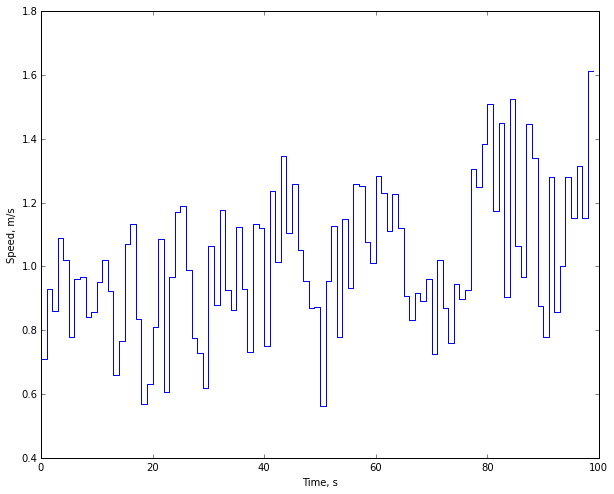

In [68]:
speed = np.zeros(n)
for i in range (len(T.value)):
    speed[i] = d[i]/T.value[i]
times = np.arange(n)
plt.figure(figsize=(10, 8))
plt.step(times, speed)
plt.xlabel('Time, s')
plt.ylabel('Speed, m/s')


In [71]:
'''Check'''
m = 0
for i in range (n):
    if (smin[i] <= speed[i] <= smax[i]):
        m+=1
print m        

100


### Problem 3. Solution.

\begin{equation*}
\begin{aligned}
& \underset{x}{\text{minimize}}
& & p^Tx \\
& \text{subject to}
& & Ax \leq b \\
&&& Cx = d
\end{aligned}
\end{equation*}

$$L(x, \lambda, \nu) = p^Tx + \lambda^T(Ax - b) + \nu^T(Cx - d),\\ \lambda\geq 0$$
$$
g(\lambda, \nu) = 
\underset{x}{\text{min}}\ L(x, \lambda, \nu) = 
\underset{x}{\text{min}}\big{[}(p^T + \lambda^TA + \nu^TC)x - \lambda^Tb - \nu^Td\big]
$$ 

$$
\underset{\lambda, \nu}{\text{max}}\ g(\lambda, \nu)= \underset{\lambda, \nu}{\text{max}}\underset{x}{\text{min}}\big{[}
(p^T + \lambda^TA + \nu^TC)x - \lambda^Tb - \nu^Td\big] \Rightarrow  
$$

So, we have a linear function without any restrictions for x. In order to avoid $g = -\inf$ because of $x$ in $(p^T + \lambda^TA + \nu^TC)x$ we use one more constraint. Dual problem:



\begin{equation*}
\begin{aligned}
& \underset{\lambda, \nu}{\text{min}}\ 
&& (\lambda^Tb + \nu^Td)\\
& \text{subject to}
& & p^T + \lambda^TA + \nu^TC = 0\\
&&& \lambda \geq 0
\end{aligned}
\end{equation*}


### Problem 4. Solution.
The objective function can be rewritten using matrices 
$Q = \begin{pmatrix} 2 & -1  \\ -1 & 2 \end{pmatrix}$
$A = \begin{pmatrix} -1 & -2  \\ -3 & -1 \end{pmatrix}$
$b = \begin{pmatrix} -1 & -1   \end{pmatrix}$

\begin{equation*}
\begin{aligned}
& \underset{x}{\text{minimize}}
& & \frac{1}{2}x^TQx \\
& \text{subject to}
& & Ax \leq b
\end{aligned}
\end{equation*}

The Lagrangian dual of a QP is also a QP: $$L(x, \lambda) = \frac{1}{2}x^TQx + \lambda^T(Ax - b)$$ and searching for min $L(x, \lambda)$ we use the condition $\Delta_xL(x, \lambda) = 0$ and find $x = - Q^{-1}A^T\lambda$. 

Dual problem:

\begin{equation*}
\begin{aligned}
& \underset{\lambda}{\text{minimize}}
& & -\frac{1}{2}\lambda^TAQ^{-1}A^T\lambda - \lambda^Tb\\
& \text{subject to}
& & \lambda \geq 0
\end{aligned}
\end{equation*}


$Q^{-1} = \frac{1}{3}\begin{pmatrix} 2 & 1  \\ 1 & 2 \end{pmatrix}$ 

$AQ^{-1}A^T = \begin{pmatrix} -0.66 & -2  \\ -2 & -0.66 \end{pmatrix}$

\begin{equation*}
\begin{aligned}
& \underset{\lambda}{\text{minimize}}
& & \frac{1}{2}\lambda^T\begin{pmatrix} -0.66 & -2  \\ -2 & -0.66 \end{pmatrix}\lambda + \lambda^T\begin{pmatrix} 1 & 1   \end{pmatrix}\\
& \text{subject to}
& & \lambda \geq 0
\end{aligned}
\end{equation*}


In [54]:
np.array([[1,2],[3,1]]) * np.linalg.inv(np.array([[2,-1],[-1,2]])) * np.array([[-1,-3],[-2,-1]])

array([[-0.66666667, -2.        ],
       [-2.        , -0.66666667]])

In [5]:
Q = np.array([[2,-1],[-1,2]])
A = np.array([[1,2],[3,1]])
b = np.array([-1,-1])

X = cvx.Variable(2)

constraints = [A*X <= b]

objective = cvx.Minimize(cvx.quad_form(X, Q)/2)

solution = cvx.Problem(objective, constraints)
solution.solve(solver = 'GUROBI')


print('Optimal value is: {0}'.format(solution.value))
print('X = {0}'.format(X.value.ravel()))


Optimal value is: 0.107143020929
X = [[-0.28571187 -0.35714396]]


In [4]:
Q_inv = np.linalg.inv(np.array([[2,-1],[-1,2]]))
A = np.array([[1,2],[3,1]])
b = np.array([-1,-1])
W = A*Q_inv*A.transpose()
print "W:", W
#L = np.linalg.cholesky(W)
J = cvx.Variable(2) #lambdas

constraints = [J >= 0]
#h = J.T*L
objective = cvx.Minimize(-cvx.quad_form(J, W)/2 - J*b)

solution = cvx.Problem(objective, constraints)
solution.solve(solver = 'GUROBI')


print('Optimal value is: {0}'.format(solution.value))
print('X = {0}'.format(J.value.ravel()))


W: [[ 0.66666667  2.        ]
 [ 2.          0.66666667]]


CvxPyDomainError: P has both positive and negative eigenvalues.